In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-stock-price-prediction/NFLX.csv


In [2]:
df = pd.read_csv("/kaggle/input/netflix-stock-price-prediction/NFLX.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


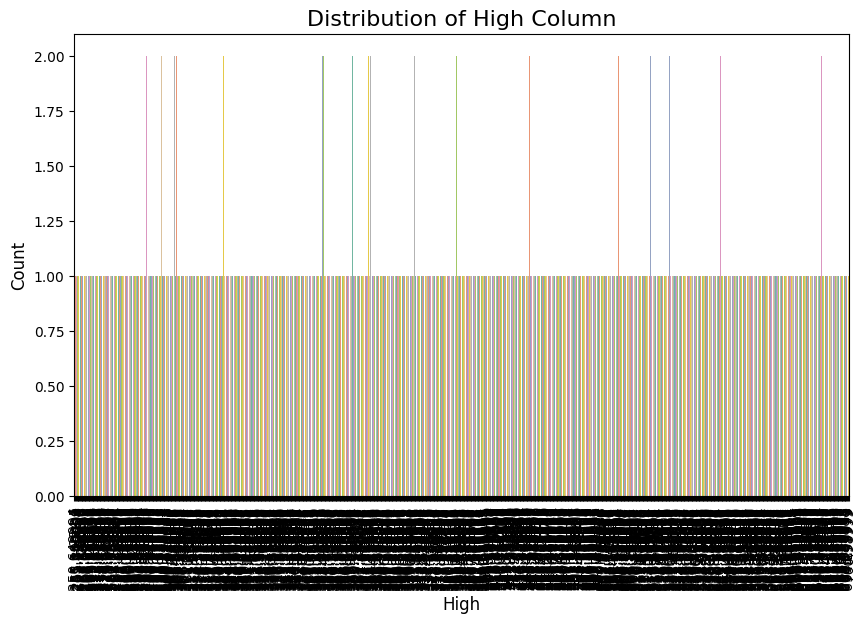

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution 
plt.figure(figsize=(10, 6))
sns.countplot(x='High', data=df, palette='Set2')

# Set labels and title
plt.title('Distribution of High Column', fontsize=16)
plt.xlabel('High', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)  # Rotate x-axis labels if needed for better readability

# Show the plot
plt.show()

In [5]:
# Print data types of all columns
print(df.dtypes)


Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [6]:
df.isnull().sum()
df.duplicated().sum()

0

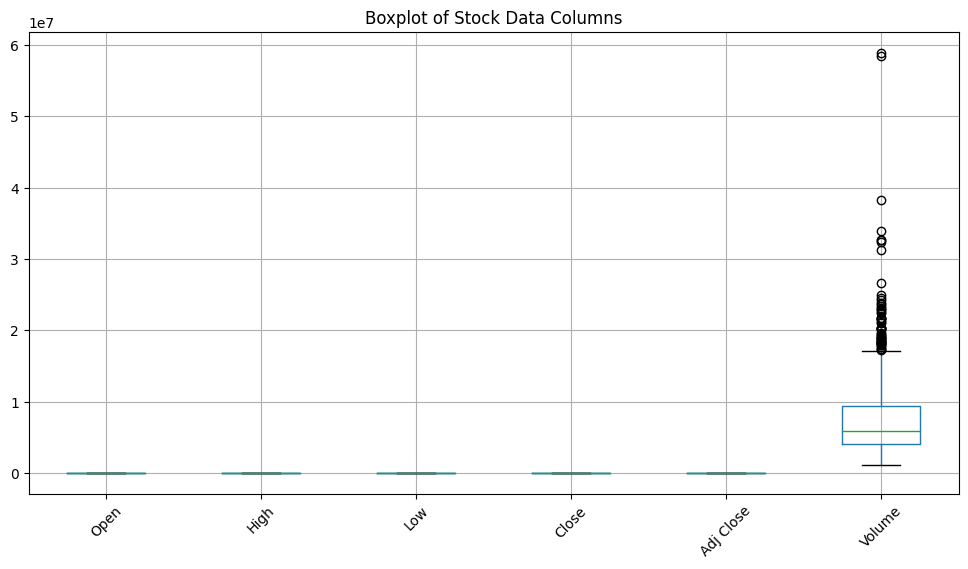

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


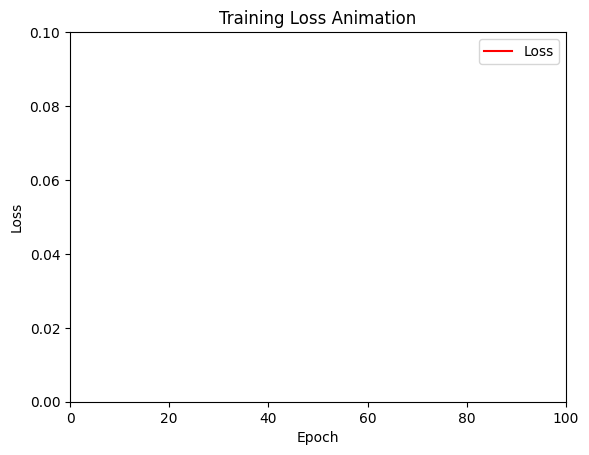

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


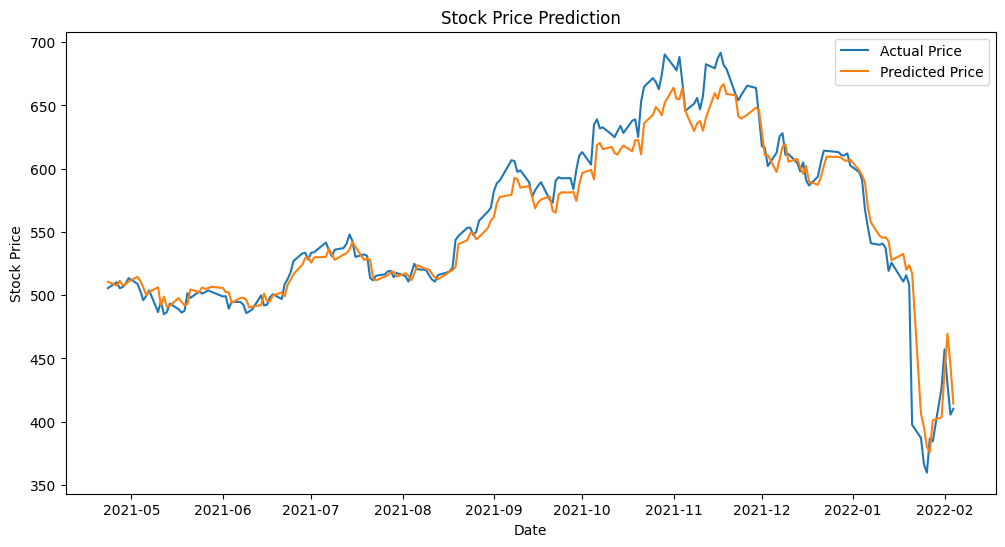

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load dataset 
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime
df = df.sort_values('Date')  # Ensure data is sorted

# Boxplot for outlier detection
plt.figure(figsize=(12, 6))
df.drop(columns=['Date']).boxplot()
plt.title('Boxplot of Stock Data Columns')
plt.xticks(rotation=45)
plt.show()

# Select the 'Close' price and normalize it
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Close']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Number of days in one sequence
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = X[:-200], y[:-200]  # Train set
X_test, y_test = X[-200:], y[-200:]  # Test set

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train with animation
loss_history = []
fig, ax = plt.subplots()
ax.set_xlim(0, 100)
ax.set_ylim(0, 0.1)
line, = ax.plot([], [], 'r', label='Loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Animation')

# Custom callback to store loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_history.append(logs['loss'])

callback = LossHistory()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[callback], verbose=0)

def update(frame):
    line.set_data(range(len(loss_history[:frame])), loss_history[:frame])
    return line,

ani = animation.FuncAnimation(fig, update, frames=range(1, 101), interval=100, blit=True)
plt.show()

# Make predictions
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-200:], y_test_rescaled, label='Actual Price')
plt.plot(df['Date'][-200:], y_pred_rescaled, label='Predicted Price')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compute evaluation metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 11.2102
Root Mean Square Error (RMSE): 16.5291
R² Score: 0.9451


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


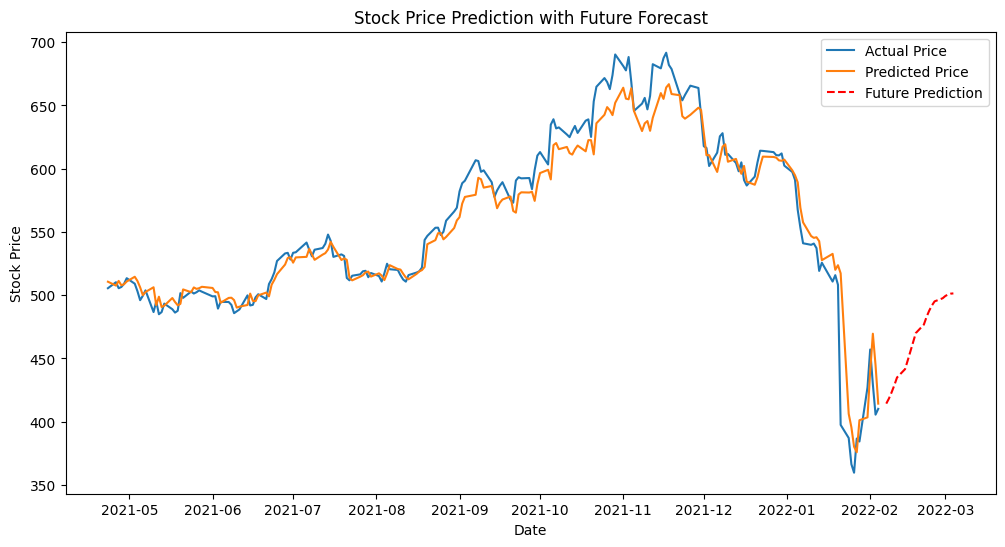

In [9]:
# Predict future values
future_days = 20  # Change this for longer-term prediction
future_input = X_test[-1]  # Start from last known sequence
future_predictions = []

for _ in range(future_days):
    next_pred = model.predict(future_input.reshape(1, seq_length, 1))
    future_predictions.append(next_pred[0, 0])
    
    # Shift the input sequence and add the new prediction
    future_input = np.roll(future_input, -1)
    future_input[-1] = next_pred

# Convert predictions back to original scale
future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(last_date, periods=future_days + 1, freq='B')[1:]  # 'B' ensures business days

# Plot Future Predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-200:], y_test_rescaled, label='Actual Price')
plt.plot(df['Date'][-200:], y_pred_rescaled, label='Predicted Price')
plt.plot(future_dates, future_predictions_rescaled, 'r--', label='Future Prediction')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with Future Forecast')
plt.show()


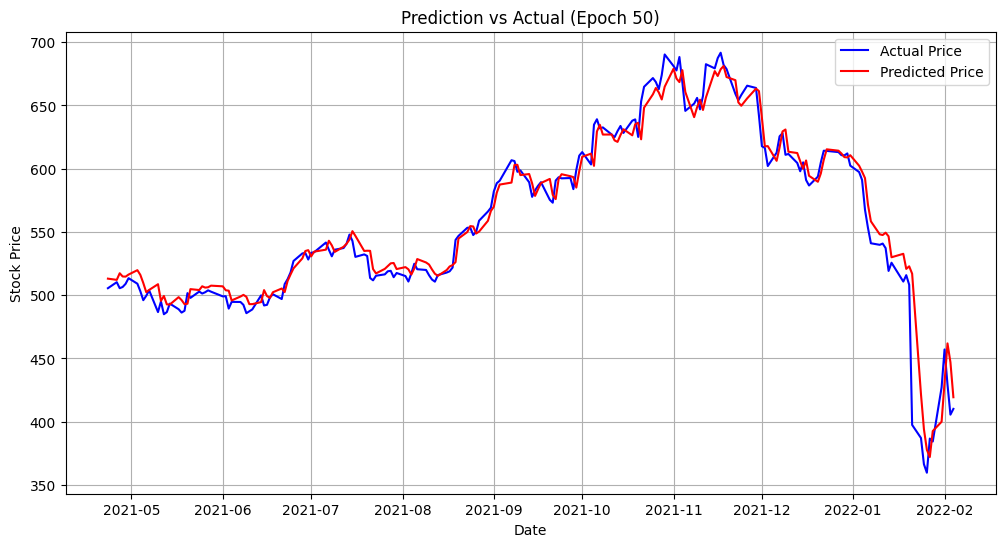

In [10]:

import IPython.display as display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import time

# Load dataset 
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Boxplot to detect outliers
plt.figure(figsize=(12, 6))
df.drop(columns=['Date']).boxplot()
plt.title('Boxplot of Stock Data')
plt.xticks(rotation=45)
plt.show()

# Normalize Close price
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Close']])

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = X[:-200], y[:-200]
X_test, y_test = X[-200:], y[-200:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Animate prediction vs actual
class PredictionAnimation(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(X_test, verbose=0)
        y_pred_rescaled = scaler.inverse_transform(y_pred)
        y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
        
        display.clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'][-200:], y_test_rescaled, label='Actual Price', color='blue')
        plt.plot(df['Date'][-200:], y_pred_rescaled, label='Predicted Price', color='red')
        plt.title(f'Prediction vs Actual (Epoch {epoch+1})')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid()
        plt.show()
        
        time.sleep(0.3)  # slight delay to show frames clearly

# Fit model with animated prediction
callback = PredictionAnimation()
model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[callback], verbose=0)

In [11]:
!apt install ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 129 not upgraded.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🎥 Animation saved as 'stock_prediction_training.mp4'


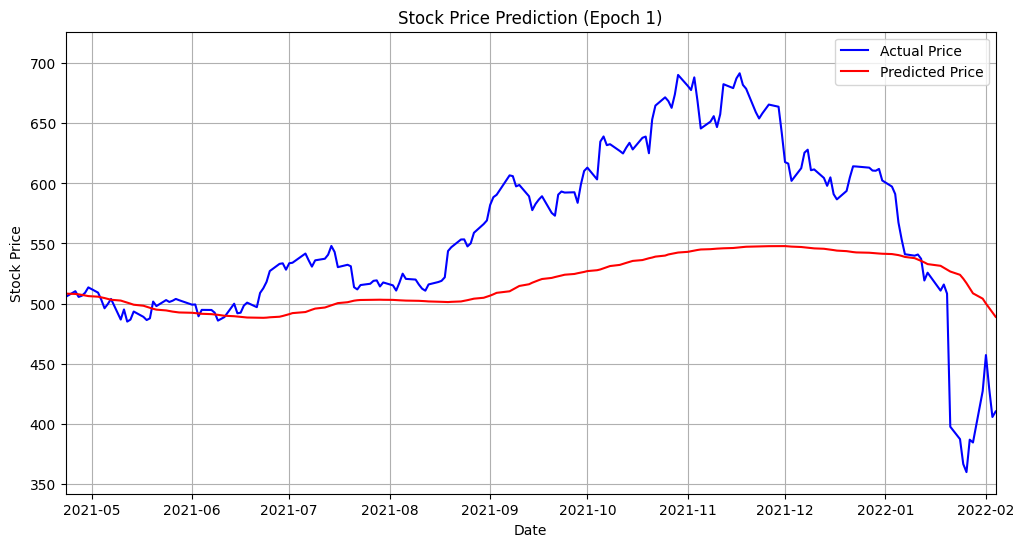

In [12]:
import matplotlib.animation as animation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Load dataset 
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Normalize 'Close' price
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Close']])

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = X[:-200], y[:-200]
X_test, y_test = X[-200:], y[-200:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Store predictions for each epoch
predictions_per_epoch = []

class StorePredictions(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(X_test, verbose=0)
        y_pred_rescaled = scaler.inverse_transform(y_pred)
        predictions_per_epoch.append(y_pred_rescaled)

# Train model with callback
callback = StorePredictions()
model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[callback], verbose=0)

# Setup animation plot
fig, ax = plt.subplots(figsize=(12, 6))
actual = scaler.inverse_transform(y_test.reshape(-1, 1))
line1, = ax.plot(df['Date'][-200:], actual, label='Actual Price', color='blue')
line2, = ax.plot([], [], label='Predicted Price', color='red')
ax.set_xlim(df['Date'].iloc[-200], df['Date'].iloc[-1])
ax.set_ylim(min(actual)*0.95, max(actual)*1.05)
ax.set_title('Stock Price Prediction Over Epochs')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.legend()
ax.grid()

def update(epoch):
    pred = predictions_per_epoch[epoch]
    line2.set_data(df['Date'][-200:], pred)
    ax.set_title(f'Stock Price Prediction (Epoch {epoch+1})')
    return line2,

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(predictions_per_epoch), interval=300, blit=False
)

# Save as mp4
writer = animation.FFMpegWriter(fps=5)
ani.save('stock_prediction_training.mp4', writer=writer)

print("🎥 Animation saved as 'stock_prediction_training.mp4'")


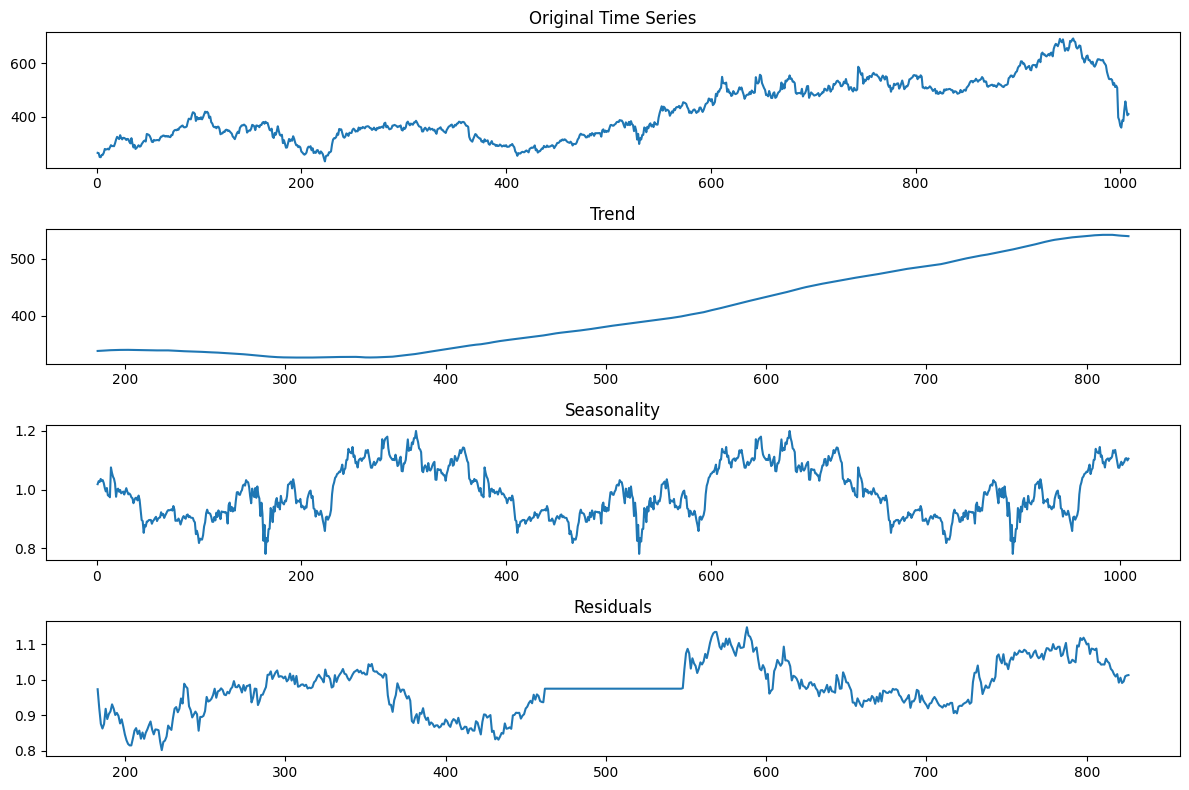

ADF Statistic: -1.7771819693277402
p-value: 0.3918475998582774
The data is non-stationary but its okay as i use LSTM.


In [35]:
import time
import imageio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Load dataset 
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime
df = df.sort_values('Date')  # Ensure data is sorted

# Select the 'Close' price for analysis
close_prices = df['Close']

# Decompose the time series (seasonality, trend, residuals)
result = seasonal_decompose(close_prices, model='multiplicative', period=365)

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(close_prices, label='Original')
plt.title('Original Time Series')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.title('Trend')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.title('Seasonality')
plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.title('Residuals')
plt.tight_layout()
plt.show()

# Test for stationarity using Augmented Dickey-Fuller Test
adf_result = adfuller(close_prices)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

if adf_result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary but its okay as i use LSTM.")


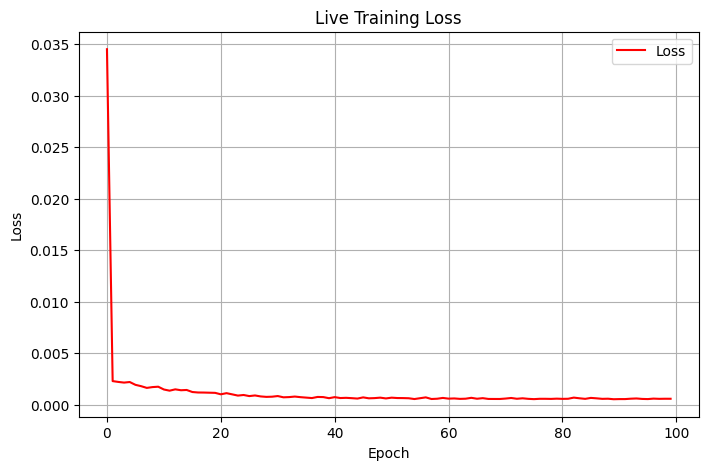

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


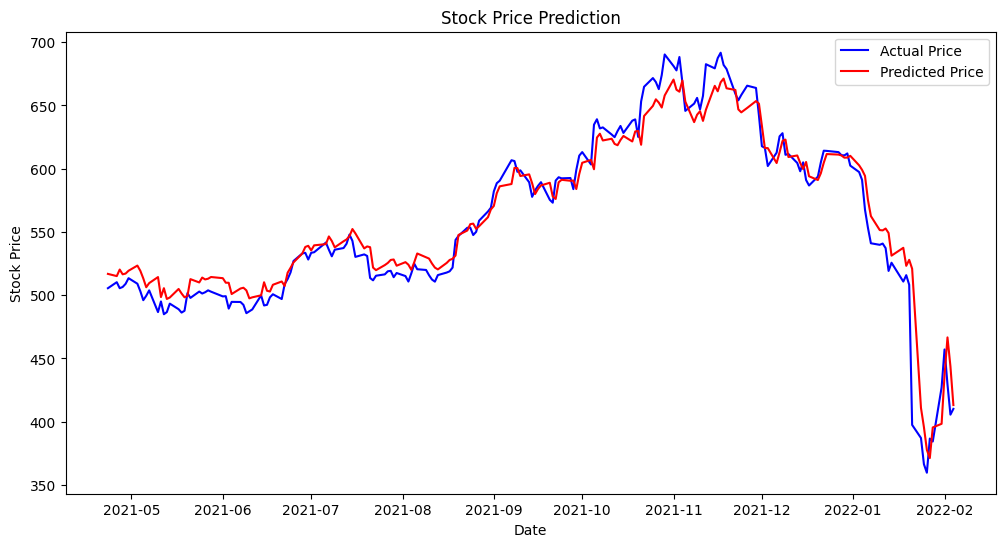

In [13]:
import IPython.display as display
from tensorflow.keras.models import Sequential
import time

# Load dataset 
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime
df = df.sort_values('Date')  # Ensure data is sorted

# Boxplot for outlier detection
plt.figure(figsize=(12, 6))
df.drop(columns=['Date']).boxplot()
plt.title('Boxplot of Stock Data Columns')
plt.xticks(rotation=45)
plt.show()

# Select the 'Close' price and normalize it
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Close']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Number of days in one sequence
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = X[:-200], y[:-200]  # Train set
X_test, y_test = X[-200:], y[-200:]  # Test set

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Live training loss plot
class LiveLossPlot(tf.keras.callbacks.Callback):
    def __init__(self):
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        
        # Clear output and update plot dynamically
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        plt.plot(self.losses, label='Loss', color='r')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Live Training Loss')
        plt.legend()
        plt.grid()
        plt.show()
        
        time.sleep(0.1)  # Small delay to improve visibility

# Train the model with live loss animation
live_plot = LiveLossPlot()
history = model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[live_plot], verbose=0)

# Make predictions
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-200:], y_test_rescaled, label='Actual Price', color='blue')
plt.plot(df['Date'][-200:], y_pred_rescaled, label='Predicted Price', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


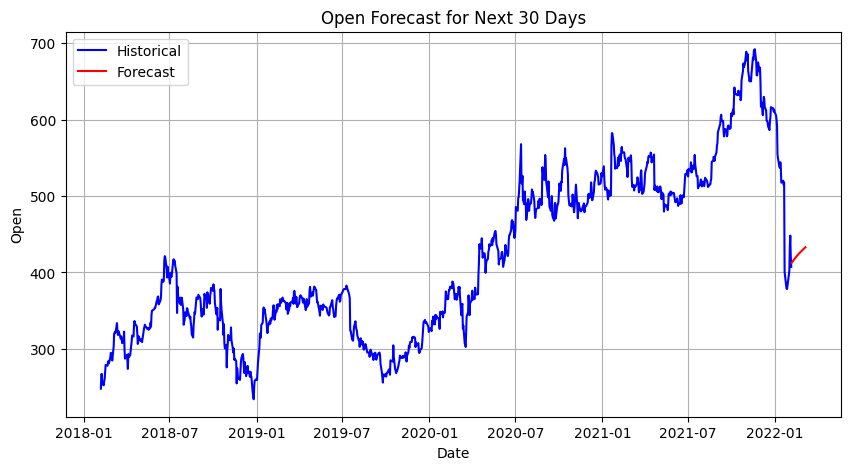

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


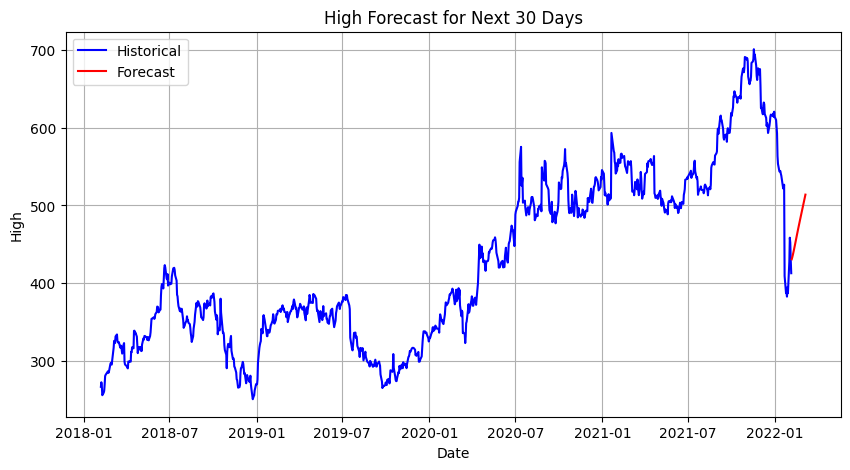

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


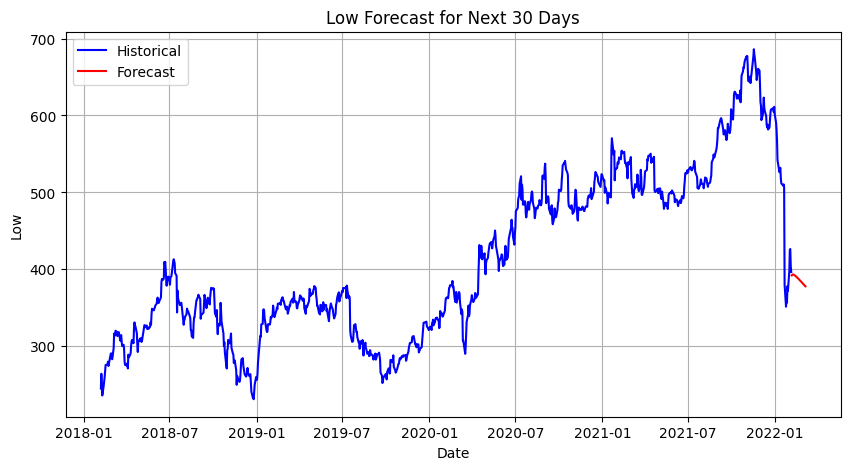

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


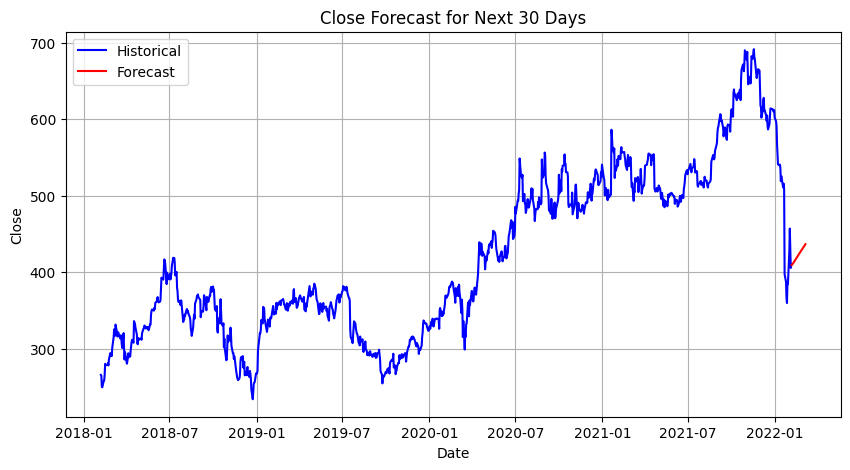

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


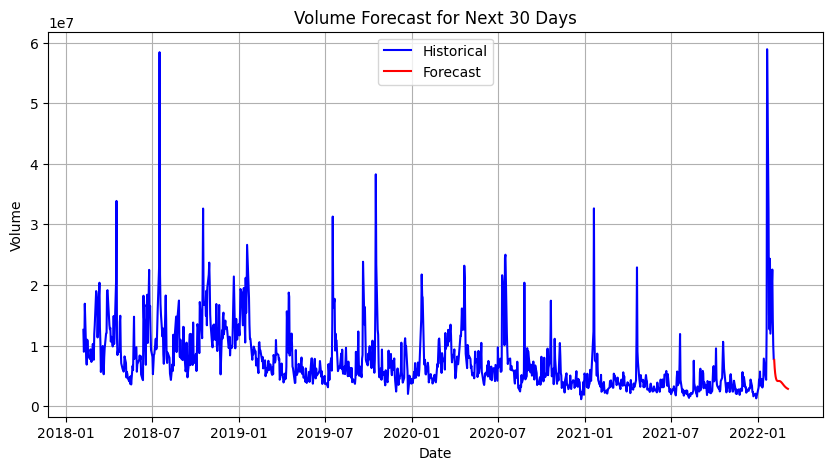

In [40]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense

# --- Configuration ---
future_days = 30
seq_length = 50
columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# --- Helper Function ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# --- Prepare Data ---
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Dictionary to store future forecasts
future_predictions = {}

# --- Loop through each column ---
for col in columns:
    # Normalize the column
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[col]])
    
    # Create sequences
    X, y = create_sequences(scaled_data, seq_length)
    X_train, y_train = X[:-200], y[:-200]

    # Build LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        LSTM(50),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    # Forecasting next 30 days
    last_seq = scaled_data[-seq_length:]
    forecast = []

    input_seq = last_seq.reshape(1, seq_length, 1)
    for _ in range(future_days):
        pred = model.predict(input_seq, verbose=0)
        forecast.append(pred[0, 0])
        
        # Fixing the dimension mismatch here:
        pred_reshaped = pred.reshape(1, 1, 1)
        input_seq = np.concatenate((input_seq[:, 1:, :], pred_reshaped), axis=1)

    # Inverse transform forecast
    forecast_rescaled = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
    future_predictions[col] = forecast_rescaled

    # Plot historical + forecast
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df[col], label='Historical', color='blue')
    future_dates = pd.date_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=future_days)
    plt.plot(future_dates, forecast_rescaled, label='Forecast', color='red')
    plt.title(f"{col} Forecast for Next {future_days} Days")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.grid()
    plt.show()
